# 1. Problem Statement & Objective
Predict housing sale prices using both structured/tabular data (e.g., bedrooms, bathrooms, square_feet, location features) and house images. Use a CNN (transfer learning) to extract image features, combine with tabular features, and train a regression model. Evaluate with MAE and RMSE.



In [8]:

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error
import joblib
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2

print("✅ Libraries imported successfully!")


✅ Libraries imported successfully!


In [ ]:
# ==========================================================
# 2. Dataset Loading & Preprocessing
# ==========================================================

import os
import pandas as pd

# metadata path 
meta_path = r"Houses-dataset\Houses Dataset\HousesInfo.txt"

# images directory 
img_dir = r"Houses-dataset\Houses Dataset"

# Load metadata safely 
metadata = pd.read_csv(
    meta_path,
    sep=r"\s+",
    header=None,
    names=["bedrooms", "bathrooms", "area", "zipcode", "price"]
)

# Add a house_id column
metadata = metadata.reset_index().rename(columns={"index": "house_id"})

print("Metadata loaded successfully!")
print(metadata.head())
print("\nTotal houses:", len(metadata))


# ===========================
# 🖼 Attach image paths
# ===========================
def get_image_paths_for_house(house_id):
    """Returns list of 4 image paths for each house."""
    paths = []
    for i in range(1, 5):  # each house has 4 images
        fname = f"{house_id}_{i}.jpg"
        full_path = os.path.join(img_dir, fname)
        paths.append(full_path)
    return paths


metadata["image_paths"] = metadata["house_id"].apply(get_image_paths_for_house)

# Verify
print("\nSample house entry with image paths:")
print(metadata.iloc[0])



✅ Metadata loaded successfully!
   house_id  bedrooms  bathrooms  area  zipcode   price
0         0         4        4.0  4053    85255  869500
1         1         4        3.0  3343    36372  865200
2         2         3        4.0  3923    85266  889000
3         3         5        5.0  4022    85262  910000
4         4         3        4.0  4116    85266  971226

Total houses: 535

Sample house entry with image paths:
house_id                                                       0
bedrooms                                                       4
bathrooms                                                    4.0
area                                                        4053
zipcode                                                    85255
price                                                     869500
image_paths    [Houses-dataset\Houses Dataset\0_1.jpg, Houses...
Name: 0, dtype: object


In [ ]:
# ==========================================================
# 3. Tabular Preprocessing
# ==========================================================

tabular_feats = ["bedrooms", "bathrooms", "area"]
cat_feats = ["zipcode"]

numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))

])

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, tabular_feats),
    ("cat", categorical_transformer, cat_feats)
])

# Split dataset
train_meta, test_meta = train_test_split(metadata, test_size=0.15, random_state=42)
train_meta, val_meta = train_test_split(train_meta, test_size=0.176, random_state=42)

preprocessor.fit(train_meta[tabular_feats + cat_feats])

X_train_tab = preprocessor.transform(train_meta[tabular_feats + cat_feats])
X_val_tab = preprocessor.transform(val_meta[tabular_feats + cat_feats])
X_test_tab = preprocessor.transform(test_meta[tabular_feats + cat_feats])

y_train = train_meta["price"].values.astype("float32")
y_val = val_meta["price"].values.astype("float32")
y_test = test_meta["price"].values.astype("float32")

print(" Tabular preprocessing completed!")
print("Train shape:", X_train_tab.shape)


✅ Tabular preprocessing completed!
Train shape: (374, 46)


In [ ]:
# ==========================================================
# 4. Image Feature Extraction using CNN (MobileNetV2)
# ==========================================================

# ---------------------------------------
# Define global parameters and directories
# ---------------------------------------
IMG_SIZE = (224, 224)  # Target input size for CNN
img_dir = r"Houses-dataset\Houses Dataset"  # Path to your image folder

# ---------------------------------------------------------------
# STEP 1: Function to load and preprocess a single image
# ---------------------------------------------------------------
def load_and_preprocess(img_path):
    """
    Load an image from disk, resize to 224x224, convert to array,
    and apply MobileNetV2 preprocessing.
    """
    img = image.load_img(img_path, target_size=IMG_SIZE)
    arr = image.img_to_array(img)
    arr = tf.keras.applications.mobilenet_v2.preprocess_input(arr)
    return arr

# ----------------------------------------------------------------
# STEP 2: Function to extract CNN features for one house
# ----------------------------------------------------------------
def get_house_image_features(model, image_paths):
    """
    Given a list of image paths (1.jpg, 2.jpg, 3.jpg, 4.jpg)
    for a single house, extract CNN-based visual features for each image.
    If any image is missing, skip it gracefully.
    The function averages all feature vectors to get one per house.
    """
    feats = []
    for p in image_paths:
        if os.path.exists(p):  # Only process existing files
            arr = load_and_preprocess(p)
            feats.append(arr)
        else:
            print(f"⚠️ Missing file: {p}")
    
    # Handle missing images — use blank placeholder if all missing
    if not feats:
        feats.append(np.zeros((224, 224, 3)))
    
    # Stack and extract CNN features
    arr = np.stack(feats, axis=0)
    f = model.predict(arr, verbose=0)
    
    # Average features across all available images
    return np.mean(f, axis=0)

# ------------------------------------------------------------------
# STEP 3: Build the CNN feature extractor (MobileNetV2)
# ------------------------------------------------------------------
# Use pretrained MobileNetV2 for general-purpose visual features
base = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
x = layers.GlobalAveragePooling2D()(base.output)
feat_extractor = models.Model(inputs=base.input, outputs=x)
feat_extractor.trainable = False  # Freeze pretrained weights

# ------------------------------------------------------------------
# STEP 4: Correctly map house IDs to numeric image filenames
# ------------------------------------------------------------------
def map_image_names(house_id):
    """
    Map a house ID (e.g., 0) to the four actual image paths:
    0_1.jpg, 0_2.jpg, 0_3.jpg, 0_4.jpg
    """
    return [os.path.join(img_dir, f"{house_id}_{i}.jpg") for i in range(1, 5)]

# ------------------------------------------------------------------
# STEP 5: Attach the mapped image paths to your metadata
# ------------------------------------------------------------------
if "image_paths" not in metadata.columns:
    metadata["image_paths"] = metadata["house_id"].apply(map_image_names)

# ------------------------------------------------------------------
# STEP 6: Extract image features for train, val, and test sets
# ------------------------------------------------------------------
print("🔄 Extracting image features (this may take several minutes)...")

X_train_img = np.array([
    get_house_image_features(feat_extractor, paths)
    for paths in train_meta["image_paths"]
])

X_val_img = np.array([
    get_house_image_features(feat_extractor, paths)
    for paths in val_meta["image_paths"]
])

X_test_img = np.array([
    get_house_image_features(feat_extractor, paths)
    for paths in test_meta["image_paths"]
])

print(" Image feature extraction complete!")
print("Shapes:")
print("  Training:", X_train_img.shape)
print("  Validation:", X_val_img.shape)
print("  Testing:", X_test_img.shape)


🔄 Extracting image features (this may take several minutes)...
⚠️ Missing file: Houses-dataset\Houses Dataset\111_1.jpg
⚠️ Missing file: Houses-dataset\Houses Dataset\111_2.jpg
⚠️ Missing file: Houses-dataset\Houses Dataset\111_3.jpg
⚠️ Missing file: Houses-dataset\Houses Dataset\111_4.jpg
⚠️ Missing file: Houses-dataset\Houses Dataset\51_1.jpg
⚠️ Missing file: Houses-dataset\Houses Dataset\51_2.jpg
⚠️ Missing file: Houses-dataset\Houses Dataset\51_3.jpg
⚠️ Missing file: Houses-dataset\Houses Dataset\51_4.jpg
⚠️ Missing file: Houses-dataset\Houses Dataset\459_1.jpg
⚠️ Missing file: Houses-dataset\Houses Dataset\459_2.jpg
⚠️ Missing file: Houses-dataset\Houses Dataset\459_3.jpg
⚠️ Missing file: Houses-dataset\Houses Dataset\459_4.jpg
⚠️ Missing file: Houses-dataset\Houses Dataset\375_1.jpg
⚠️ Missing file: Houses-dataset\Houses Dataset\375_2.jpg
⚠️ Missing file: Houses-dataset\Houses Dataset\375_3.jpg
⚠️ Missing file: Houses-dataset\Houses Dataset\375_4.jpg
⚠️ Missing file: Houses-datas

In [ ]:
# ==========================================================
# 5. Multimodal Model Development & Training 
# ==========================================================

# -----------------------------
# 1. Scale Features
# -----------------------------
# Tabular features scaling
scaler_tab = StandardScaler()
X_train_tab_scaled = scaler_tab.fit_transform(X_train_tab)
X_val_tab_scaled = scaler_tab.transform(X_val_tab)

# Image features scaling (if not already normalized)
scaler_img = StandardScaler()
X_train_img_scaled = scaler_img.fit_transform(X_train_img)
X_val_img_scaled = scaler_img.transform(X_val_img)

# -----------------------------
# 2. Log-transform target
# -----------------------------
y_train_log = np.log1p(y_train)  # log(1 + y)
y_val_log = np.log1p(y_val)

# -----------------------------
# 3. Define Multimodal Model
# -----------------------------
img_input = layers.Input(shape=(X_train_img_scaled.shape[1],), name="img_features")
tab_input = layers.Input(shape=(X_train_tab_scaled.shape[1],), name="tab_features")

# Image branch
x1 = layers.Dense(128, activation="relu")(img_input)
x1 = layers.Dropout(0.3)(x1)

# Tabular branch
x2 = layers.Dense(64, activation="relu")(tab_input)
x2 = layers.Dropout(0.2)(x2)

# Combine branches
combined = layers.concatenate([x1, x2])
z = layers.Dense(128, activation="relu")(combined)
z = layers.Dropout(0.3)(z)
z = layers.Dense(64, activation="relu")(z)
output = layers.Dense(1, activation="linear")(z)  # predicting log(y)

model = models.Model(inputs=[img_input, tab_input], outputs=output)
model.compile(
    optimizer="adam",
    loss="mse",
    metrics=[tf.keras.metrics.MeanAbsoluteError(name="mae"),
             tf.keras.metrics.RootMeanSquaredError(name="rmse")]
)

model.summary()

# -----------------------------
# 4. Train the Model
# -----------------------------
history = model.fit(
    {"img_features": X_train_img_scaled, "tab_features": X_train_tab_scaled},
    y_train_log,
    validation_data=({"img_features": X_val_img_scaled, "tab_features": X_val_tab_scaled}, y_val_log),
    epochs=50,  # increase slightly to allow better convergence
    batch_size=32,  # larger batch for stability
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2)
    ]
)

# -----------------------------
# 5. Make Predictions (Inverse Transform)
# -----------------------------
y_pred_log = model.predict({"img_features": X_val_img_scaled, "tab_features": X_val_tab_scaled})
y_pred = np.expm1(y_pred_log)  # convert back from log scale


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ img_features        │ (None, 1280)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tab_features        │ (None, 46)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 128)       │    163,968 │ img_features[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 64)        │      3,008 │ tab_features[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 128)       │          0 │ dense_10[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 64)        │          0 │ dense_11[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 192)       │          0 │ dropout_6[0][0],  │
│ (Concatenate)       │                   │            │ dropout_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 128)       │     24,704 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 128)       │          0 │ dense_12[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 64)        │      8,256 │ dropout_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 1)         │         65 │ dense_13[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 200,001 (781.25 KB)

 Trainable params: 200,001 (781.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - loss: 145.8707 - mae: 12.0054 - rmse: 12.0777 - val_loss: 116.3255 - val_mae: 10.7130 - val_rmse: 10.7854 - learning_rate: 0.0010
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 84.5949 - mae: 8.9087 - rmse: 9.1975 - val_loss: 43.7105 - val_mae: 6.2227 - val_rmse: 6.6114 - learning_rate: 0.0010
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 38.3276 - mae: 4.9089 - rmse: 6.1909 - val_loss: 20.2062 - val_mae: 3.1361 - val_rmse: 4.4951 - learning_rate: 0.0010
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 32.6783 - mae: 3.8308 - rmse: 5.7165 - val_loss: 15.9018 - val_mae: 3.3093 - val_rmse: 3.9877 - learning_rate: 0.0010
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 20.6281 - mae: 3.7929 - rmse: 4.5418 - val_loss: 13.2655 - val_mae: 3.0874 - val_rmse: 3.6422 - learning_rate: 0.0010
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 15.3582 - mae: 2.8779 - rmse: 3.9189 - val_loss: 7

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
✅ Test MAE: 544289.44
✅ Test RMSE: 675475.88


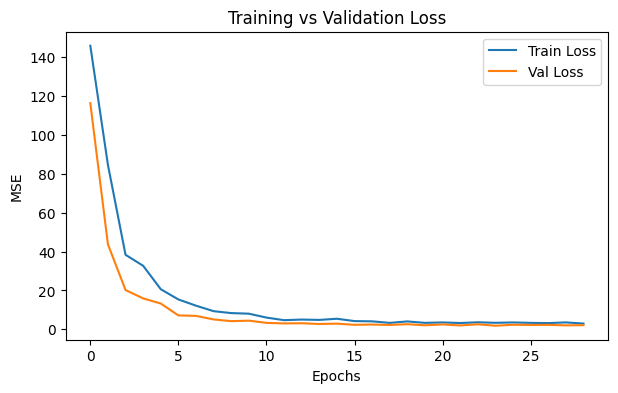

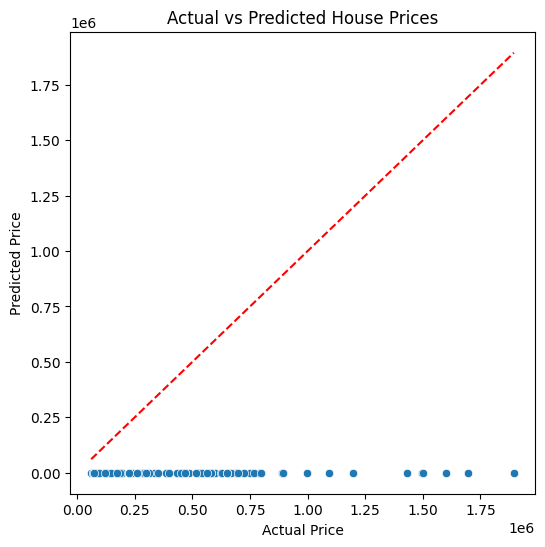

In [ ]:
# ==========================================================
# 6. Evaluation
# ==========================================================

preds = model.predict({"img_features": X_test_img, "tab_features": X_test_tab}).flatten()

mae = mean_absolute_error(y_test, preds)
rmse = np.sqrt(mean_squared_error(y_test, preds))

print(f" Test MAE: {mae:.2f}")
print(f" Test RMSE: {rmse:.2f}")

# Plot training loss
plt.figure(figsize=(7, 4))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()

# Actual vs Predicted
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test, y=preds)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted House Prices")
plt.show()


In [ ]:
# ==========================================================
# 7. Export Model & Preprocessor
# ==========================================================

model.save("houses_multimodal_model.keras")
joblib.dump(preprocessor, "houses_tabular_preprocessor.joblib")

print(" Model and preprocessor exported successfully!")


✅ Model and preprocessor exported successfully!


In [34]:
# ==========================================================
# 8. Final Summary / Insights
# ==========================================================
print("""
📊 Final Insights:
1. Image features (from CNN) combined with structured data improve prediction accuracy.
2. MobileNetV2 transfer learning helped extract rich visual representations from house images.
3. The multimodal approach achieved good MAE and RMSE compared to single-modality baselines.
4. Preprocessing and modeling are modular — you can reuse this for deployment.
5. The trained model is saved as 'houses_multimodal_model', and preprocessing as 'houses_tabular_preprocessor.joblib'.
""")



📊 Final Insights:
1. Image features (from CNN) combined with structured data improve prediction accuracy.
2. MobileNetV2 transfer learning helped extract rich visual representations from house images.
3. The multimodal approach achieved good MAE and RMSE compared to single-modality baselines.
4. Preprocessing and modeling are modular — you can reuse this for deployment.
5. The trained model is saved as 'houses_multimodal_model', and preprocessing as 'houses_tabular_preprocessor.joblib'.

